### 基础作业

#### 欧阳硕，18023034


本作业已同步至[GitHub](https://github.com/Litt1e0range/Deep-Learning-Methods-and-Practices)

---

首先引入相关的模块，其中utils模块实现了`get_minibatch`、`get_mnist`等函数。

In [12]:
import tensorflow as tf
from model import Model
from utils import get_minibatches,  pair_generator, get_mnist
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import time
import warnings
warnings.filterwarnings("ignore")

接下来实现基础作业的模型。首先实现输入数据和标签的占位符，注意这里两个输入总的维度是782，两个输入各占一半。私有函数`__linear_func`实现了矩阵乘法，并在`add_prediction_op`函数中进行变量共享。损失函数使用tensorflow自带的`softmax`损失函数。在训练过程中，每10个epoch进行一次测试，并将结果打印在屏幕上。

In [13]:
class BasicModel(Model):
    def __init__(self, config):
        self.config = config
        self.param = {}
        self.build()
    def add_placeholders(self):
        self.inputs_placeholder_1 = tf.placeholder(tf.float32, [None, self.config.n_features // 2])
        self.inputs_placeholder_2 = tf.placeholder(tf.float32, [None, self.config.n_features // 2])
        self.labels_placeholder = tf.placeholder(tf.float32, [None, self.config.n_classes])
    def create_feed_dict(self, inputs_batch_1, inputs_batch_2, labels_batch=None):
        feed_dict = {
            self.inputs_placeholder_1: inputs_batch_1,
            self.inputs_placeholder_2: inputs_batch_2
        }
        if labels_batch is not None:
            feed_dict[self.labels_placeholder] = labels_batch
        return feed_dict
    def __linear_func(self, X):
        ans = None
        W = tf.get_variable("W", [self.config.n_features // 2, self.config.n_classes],
                            dtype=tf.float32, initializer=tf.initializers.glorot_uniform)
        ans = tf.matmul(X, W)
        return ans
    def add_prediction_op(self):
        X_1 = self.inputs_placeholder_1
        X_2 = self.inputs_placeholder_2
        b = tf.Variable(tf.zeros([self.config.n_classes]), name="b", dtype=tf.float32)
        pred = None
        with tf.variable_scope("first_layer") as scope:
            o_1 = self.__linear_func(X_1)
            scope.reuse_variables()
            o_2 = self.__linear_func(X_2)
            pred = tf.nn.softmax(o_1 + o_2 + b)
        return pred
    def add_loss_op(self, pred):
        y = self.labels_placeholder
        loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(y, pred))
        return loss
    def add_training_op(self, loss):
        optimizer = tf.train.AdamOptimizer(self.config.lr)
        train_op = optimizer.minimize(loss)
        return train_op
    def fit(self, sess, inputs_1, inputs_2, labels):
        losses = []
        for epoch in range(self.config.n_epochs):
            start_time = time.time()
            average_loss = self.run_epoch(sess, inputs_1, inputs_2, labels)
            duration = time.time() - start_time
            if epoch % 10 == 0:
                y_pred = self.predict(sess, inputs_1, inputs_2)
                accuracy = self.score(sess, labels, y_pred)
                print("Epoch {:}: training loss = {:.6f}, training accuracy = {:.3f} ({:.3f} sec)".format(
                    epoch, average_loss, accuracy, duration))
            losses.append(average_loss)
        return losses
    def predict(self, sess, inputs_1, inputs_2):
        pred = []
        for input_batch_1, input_batch_2 in get_minibatches([inputs_1, inputs_2], self.config.batch_size):
            pred.extend(self.predict_on_batch(sess, input_batch_1, input_batch_2))
        return np.array(pred)
    def score(self, sess, labels, pred):
        correct = tf.equal(tf.argmax(labels, 1), tf.argmax(pred, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
        acc = sess.run(accuracy)
        return acc

接下来实现配置类，所有的超参数都在该类中设置：

In [14]:
class Config():
    def __init__(self, n_sampls=60000, n_features=784, n_classes=10, batch_size=64, n_epochs=2000, lr=1e-4, n_hidden=[128, 10]):
        self.n_sampls = n_sampls
        self.n_features = n_features
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lr = lr
        self.n_hidden = n_hidden

下面实现基础作业的训练过程。根据配置类的参数可以看出，batch_size为128，学习率为0.01，一共训练200个epoch。训练结束后，将测试准确率打印在屏幕上。

In [15]:
def basic_assignment():
    X_train, X_test, y_train,  y_test = get_mnist()
    config = Config(batch_size=128, lr=1e-2, n_epochs=200)
    with tf.Graph().as_default() as graph:
        model = BasicModel(config)
        init_op = tf.global_variables_initializer()
        with tf.Session(graph=graph) as sess:
            sess.run(init_op)
            sz = config.n_features // 2
            model.fit(sess, X_train[:, :sz], X_train[:, sz:], y_train)
            y_pred = model.predict(sess, X_test[:, :sz], X_test[:, sz:])
            accuracy = model.score(sess, y_test, y_pred)
            print("* Accuracy on test set = {:.3f}".format(accuracy))

运行该函数，得到如下结果。

In [16]:
basic_assignment()

Epoch 0: training loss = 1.693072, training accuracy = 0.818 (0.713 sec)
Epoch 10: training loss = 1.552052, training accuracy = 0.910 (0.621 sec)
Epoch 20: training loss = 1.546135, training accuracy = 0.916 (0.681 sec)
Epoch 30: training loss = 1.543120, training accuracy = 0.914 (0.638 sec)
Epoch 40: training loss = 1.540596, training accuracy = 0.916 (0.620 sec)
Epoch 50: training loss = 1.538319, training accuracy = 0.918 (0.617 sec)
Epoch 60: training loss = 1.536800, training accuracy = 0.918 (0.577 sec)
Epoch 70: training loss = 1.536035, training accuracy = 0.917 (0.594 sec)
Epoch 80: training loss = 1.535129, training accuracy = 0.921 (0.584 sec)
Epoch 90: training loss = 1.534163, training accuracy = 0.920 (0.751 sec)
Epoch 100: training loss = 1.533783, training accuracy = 0.920 (0.571 sec)
Epoch 110: training loss = 1.533058, training accuracy = 0.923 (0.582 sec)
Epoch 120: training loss = 1.532636, training accuracy = 0.923 (0.627 sec)
Epoch 130: training loss = 1.531970,

可以看到，最终测试集上的准确率为0.906,效果还算不错。


### 进阶作业
---

为进阶作业编三层网络模型，每一层都包含128个神经元，私有函数`__add_dense_layer`的功能是添加一个全连接层。这里为了方便训练，使用的损失函数为：

$$
L(W,Y,\vec{X_1},\vec{X_2}) = (1-Y)\frac{1}{2}(E_W)^2 + (Y)\frac{1}{2}\{\max(0,margin-E_W)\}^2
$$

该损失函数参考[这篇文章](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

In [17]:
class AdvancedModel(Model):
    def __init__(self, config):
        self.config = config
        self.param = {}
        super().__init__()
    def add_placeholders(self):
        self.inputs_placeholder_1 = tf.placeholder(tf.float32, [None, self.config.n_features])
        self.inputs_placeholder_2 = tf.placeholder(tf.float32, [None, self.config.n_features])
        self.labels_placeholder = tf.placeholder(tf.float32, [None, 1])
    def create_feed_dict(self, inputs_batch_1, inputs_batch_2, labels_batch=None):
        feed_dict = {
            self.inputs_placeholder_1: inputs_batch_1,
            self.inputs_placeholder_2: inputs_batch_2
        }
        if labels_batch is not None:
            feed_dict[self.labels_placeholder] = labels_batch
        return feed_dict
    def __add_dense_layer(self, inputs, shape, activation="relu", variable_scope=None):
        W = tf.get_variable(variable_scope + "/W", [shape[0], shape[-1]], initializer=tf.initializers.glorot_uniform)
        b = tf.get_variable(variable_scope + "/b", [shape[-1]], initializer=tf.initializers.zeros)
        out = None
        if activation == "relu":
            out = tf.nn.relu(tf.matmul(inputs, W) + b)
        elif activation == "softmax":
            out = tf.nn.softmax(tf.matmul(inputs, W) + b)
        elif activation == "sigmoid":
            out = tf.nn.sigmoid(tf.matmul(inputs, W) + b)
        return out
    def add_prediction_op(self):
        pred = None
        X_1 = self.inputs_placeholder_1
        X_2 = self.inputs_placeholder_2
        with tf.variable_scope("input_layer") as scope:
            input_1 = self.__add_dense_layer(
                X_1, [self.config.n_features, self.config.n_hidden[0]], variable_scope="input_layer")
            scope.reuse_variables()
            input_2 = self.__add_dense_layer(
                X_2, [self.config.n_features, self.config.n_hidden[0]], variable_scope="input_layer")
        with tf.variable_scope("hidden_layer") as scope:
            hidden_1 = self.__add_dense_layer(
                input_1, [self.config.n_hidden[0], self.config.n_hidden[1]], variable_scope="hidden_layer")
            scope.reuse_variables()
            hidden_2 = self.__add_dense_layer(
                input_2, [self.config.n_hidden[0], self.config.n_hidden[1]], variable_scope="hidden_layer")
        with tf.variable_scope("output_layer") as scope:
            output_1 = self.__add_dense_layer(
                hidden_1, [self.config.n_hidden[1], self.config.n_hidden[2]], activation="relu", variable_scope="output_layer")
            scope.reuse_variables()
            output_2 = self.__add_dense_layer(
                hidden_2, [self.config.n_hidden[1], self.config.n_hidden[2]], activation="relu", variable_scope="output_layer")
        sum_square = tf.reduce_sum(tf.square(output_1 - output_2), reduction_indices=[1], keepdims=True)
        pred = tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))
        return pred
    def add_loss_op(self, pred):
        Ew = pred
        margin = 1
        y = self.labels_placeholder
        # margin = tf.constant(1, dtype=tf.float32, shape=[1])
        # pos = tf.multiply(tf.multiply(1 - y, 2 / margin), tf.square(Ew))
        # neg = tf.multiply(tf.multiply(y, 2 * margin), tf.exp(-2.77 / margin * Ew))
        # loss = tf.reduce_mean(pos + neg)
        square_pred = tf.square(Ew)
        margin_square = tf.square(tf.maximum(margin - pred, 0))
        loss = tf.reduce_mean(y * square_pred + (1 - y) * margin_square)
        return loss
    def add_training_op(self, loss):
        optimizer = tf.train.AdamOptimizer(self.config.lr)
        train_op = optimizer.minimize(loss)
        return train_op

    def fit(self, sess, inputs_1, inputs_2, labels):
        losses = []
        for epoch in range(self.config.n_epochs):
            start_time = time.time()
            average_loss = self.run_epoch(sess, inputs_1, inputs_2, labels)
            duration = time.time() - start_time
            if epoch % 1 == 0:
                y_pred = self.predict(sess, inputs_1, inputs_2)
                accuracy = self.score(sess, labels, y_pred)
                print("Epoch {:}: training loss = {:.6f}, training accuracy = {:.3f} ({:.3f} sec)".format(
                    epoch, average_loss, accuracy, duration))
            losses.append(average_loss)
        return losses
    def predict(self, sess, inputs_1, inputs_2):
        pred = []
        for input_batch_1, input_batch_2 in get_minibatches([inputs_1, inputs_2], self.config.batch_size):
            pred.extend(self.predict_on_batch(sess, input_batch_1, input_batch_2))
        return np.array(pred) < .5
    def score(self, sess, labels, preds):
        correct = tf.equal(tf.cast(labels, "float"), tf.cast(preds, "float"))
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
        acc = sess.run(accuracy)
        return acc

下面实现三层网络模型的训练过程，并画出测试集上的ROC曲线：

In [18]:
def advanced_assignment():
    config = Config(batch_size=128, lr=1e-3, n_epochs=20, n_hidden=[128, 128, 128], n_classes=1)

    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(
        r"E:\Deep-Learning-Methods-and-Practices\assignment3\data\mnist.npz")
    X_train, y_train = pair_generator(X_train, y_train)
    X_test, y_test = pair_generator(X_test, y_test)
    with tf.Graph().as_default() as graph:
        model = AdvancedModel(config)
        init_op = tf.global_variables_initializer()
        with tf.Session(graph=graph) as sess:
            sess.run(init_op)
            model.fit(sess, X_train[:, 0], X_train[:, 1], y_train)
            y_pred = model.predict(sess, X_test[:, 0], X_test[:, 1])
            accuracy = model.score(sess, y_test, y_pred)
            print("* Accuracy on test set = {:.3f}".format(accuracy))
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="best")
    plt.show()

运行并查看结果：

Epoch 0: training loss = 0.092577, training accuracy = 0.652 (4.305 sec)
Epoch 1: training loss = 0.077159, training accuracy = 0.740 (3.902 sec)
Epoch 2: training loss = 0.071687, training accuracy = 0.765 (4.134 sec)
Epoch 3: training loss = 0.061909, training accuracy = 0.826 (4.272 sec)
Epoch 4: training loss = 0.047333, training accuracy = 0.819 (3.985 sec)
Epoch 5: training loss = 0.037705, training accuracy = 0.834 (4.084 sec)
Epoch 6: training loss = 0.029507, training accuracy = 0.833 (4.102 sec)
Epoch 7: training loss = 0.023830, training accuracy = 0.858 (4.367 sec)
Epoch 8: training loss = 0.020609, training accuracy = 0.858 (4.065 sec)
Epoch 9: training loss = 0.018103, training accuracy = 0.870 (4.137 sec)
Epoch 10: training loss = 0.016009, training accuracy = 0.883 (4.157 sec)
Epoch 11: training loss = 0.014832, training accuracy = 0.885 (3.914 sec)
Epoch 12: training loss = 0.013225, training accuracy = 0.886 (4.133 sec)
Epoch 13: training loss = 0.013657, training acc

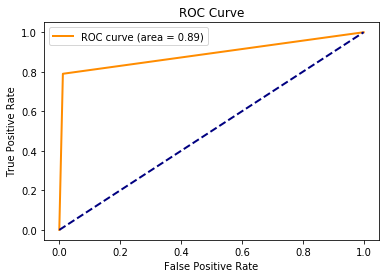

In [19]:
advanced_assignment()